## Assignment 1: Deep Learning Fundamentals -- Perceptron


This assignment is aimed at predicting diabiets using Pima Indian Diabiets dataset.

In [1]:
# Importing libraries. 
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import torch

from sklearn.datasets import load_svmlight_file
from sklearn.model_selection import train_test_split


import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset


# Avoid non-essential warnings 
# import warnings
# warnings.filterwarnings('ignore')


### 1 Data Loading and Pre-processing

Load the original data to explore the distribution of each feature and label.

In [2]:
data = pd.read_csv("diabetes.csv")

In [3]:
data.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


There is no Nan value of the dataset and all features are numerical.

In [5]:
# Extract the feature names and label names
features = data.columns[:-1] 
labels  = data.columns[-1]

In [6]:
data.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


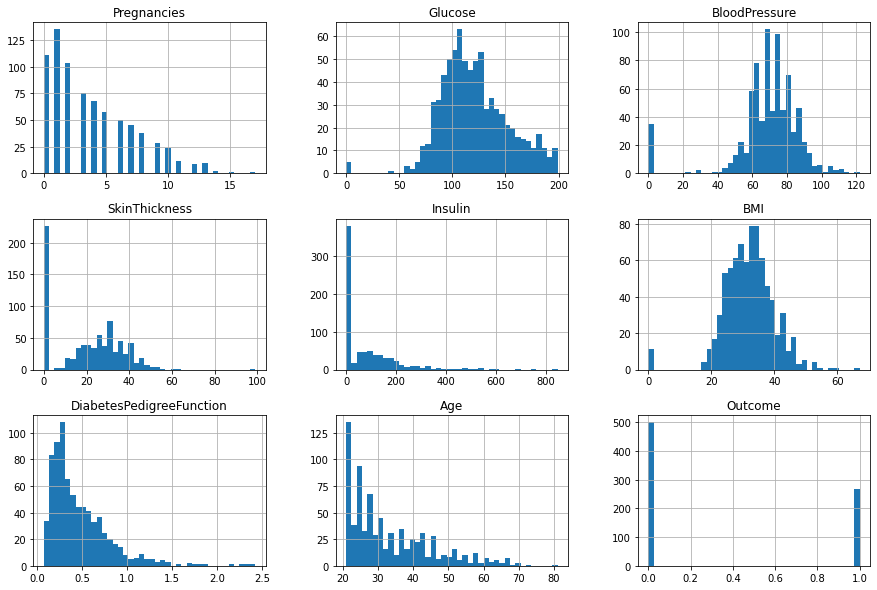

In [7]:
data_hist = data.hist(bins=40, figsize=(15, 10))

In [8]:
def bar_plot(axes, feature, index):
    sns.boxplot(x=data[feature], ax=axes[index // 2, index % 2])
    axes[index // 2, index % 2].set_xlabel(feature)

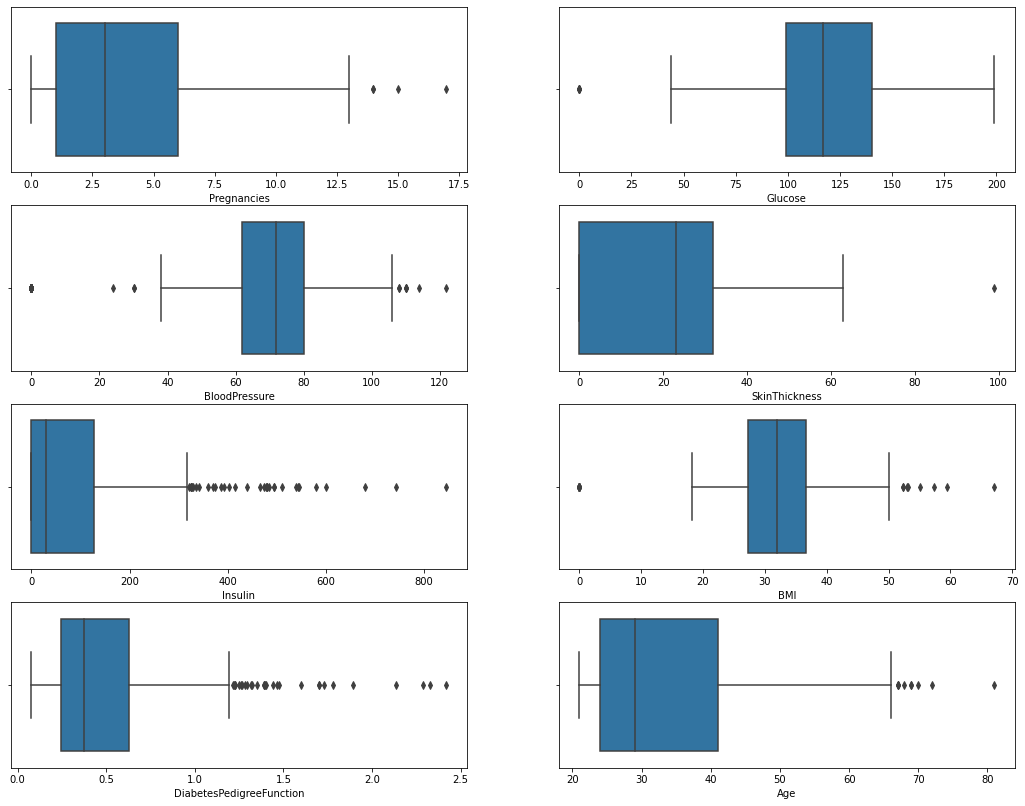

In [9]:
fig, axes = plt.subplots(4, 2, figsize=(18, 14))

for idx, feature in enumerate(features):
    bar_plot(axes, feature, idx)

It is obvious that most features of this dataset are left or right skewed with some ouliers. The dataset need to be cleaned. 

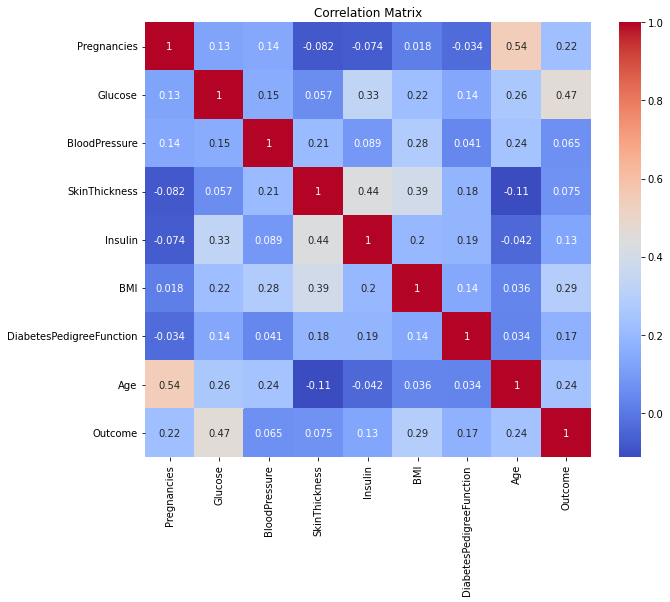

In [10]:
correlation_matrix = data.corr()  
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')  
plt.title('Correlation Matrix')  
plt.show()

It is shown in the correlation matrix that skinthickness and bloodpressure has the lowest correlation with the outcome. In the expirement following, we could consider to drop out these two features as they might not infect the result.

Use cleaned and scaled data for further processing.  
  
Normally, data scaling should be applied after splitting the data to avoid data leaking. In this case, as the dataset has been scaled into -1 and 1 using StandardScaler. And we need to assume the valid and test data are all the same distribution of train dataset. And the scaled data is recommended. So this data leakage can be ignored in this case.  
  
Convert -1 in y to 0 so that the labels match the expected output of the sigmoid function (0 or 1)


In [11]:
X, y = load_svmlight_file('diabetes_scale.txt')
y = np.where(y == -1, 0, y)

### 2. Dataset Splitting

In [12]:
# Split the data set into train, valid and test with proportion of 70%, 15%, 15%.
X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.15, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_train_full, y_train_full, test_size=0.1765, random_state=42)


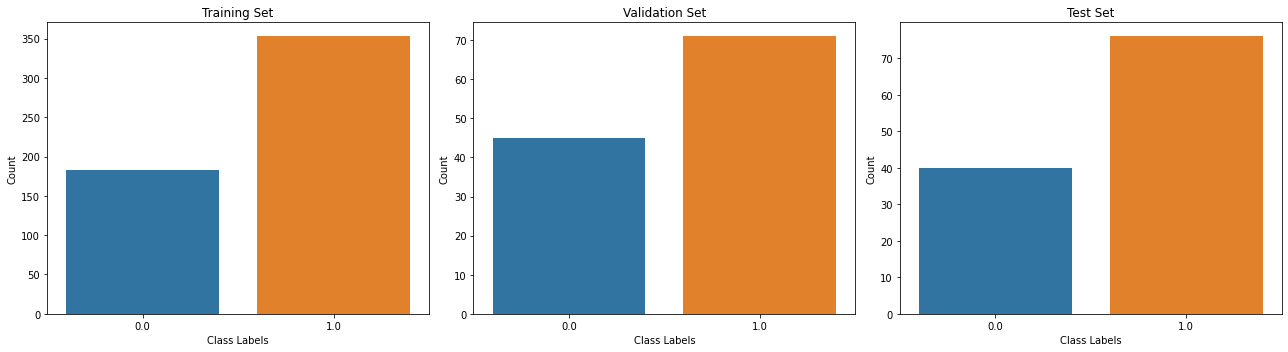

In [13]:
# Check the distribution of labels are same in train, valid and test dataset.
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
sns.countplot(ax=axes[0], x=y_train)
axes[0].set_title("Training Set")
axes[0].set_xlabel("Class Labels")
axes[0].set_ylabel("Count")

sns.countplot(ax=axes[1], x=y_valid)
axes[1].set_title("Validation Set")
axes[1].set_xlabel("Class Labels")
axes[1].set_ylabel("Count")

sns.countplot(ax=axes[2], x=y_test)
axes[2].set_title("Test Set")
axes[2].set_xlabel("Class Labels")
axes[2].set_ylabel("Count")

plt.tight_layout()
plt.show()


In [14]:
# Convert dataset into tensor for pytorch
X_train_tensor = torch.tensor(X_train.toarray(), dtype=torch.float32)
X_valid_tensor = torch.tensor(X_valid.toarray(), dtype=torch.float32)
X_test_tensor = torch.tensor(X_test.toarray(), dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
y_valid_tensor = torch.tensor(y_valid, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

print(f"X_train_tensor shape: {X_train_tensor.shape}")
print(f"X_valid_tensor shape: {X_valid_tensor.shape}")
print(f"X_test_tensor shape: {X_test_tensor.shape}")

X_train_tensor shape: torch.Size([536, 8])
X_valid_tensor shape: torch.Size([116, 8])
X_test_tensor shape: torch.Size([116, 8])


### 3 Baseline

In [15]:
class Perceptron(nn.Module):
    def __init__(self, input_dim):
        super(Perceptron, self).__init__()
        self.fc = nn.Linear(input_dim, 1)# Define a linear layer which has the same dimension with input

    def forward(self, x):
        return torch.sigmoid(self.fc(x))

input_dim = X_train_tensor.shape[1]
model = Perceptron(input_dim)

criterion = nn.BCELoss()  
optimizer = optim.SGD(model.parameters(), lr=0.01)

In [16]:
# Create dataset and dataloader
dataset = TensorDataset(X_train_tensor, y_train_tensor)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

In [17]:
# Define a function to train the model
def model_train(model, num_epochs, criterion, optimizer, dataloader):
    for epoch in range(num_epochs):
        for X_batch, y_batch in dataloader:
            outputs = model(X_batch).squeeze()
            loss = criterion(outputs, y_batch)

            # Backpropagation and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        if (epoch+1) % 10 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')
            
    return model

In [18]:
# Define a function to test the model
def test_model(model, X_test_tensor, y_test_tensor):
    with torch.no_grad():
        outputs = model(X_test_tensor).squeeze()
        predicted = (outputs > 0.5).float()  # Convert probabilities to class labels (0 or 1)
        accuracy = (predicted == y_test_tensor).sum().item() / y_test_tensor.size(0)
        return accuracy

In [19]:
num_epochs = 50
model = model_train(model, num_epochs, criterion, optimizer, dataloader)

Epoch [10/50], Loss: 0.6220
Epoch [20/50], Loss: 0.5860
Epoch [30/50], Loss: 0.5855
Epoch [40/50], Loss: 0.5821
Epoch [50/50], Loss: 0.5736


In [20]:
accuracy_baseline = test_model(model, X_valid_tensor, y_valid_tensor)
print(f'Baseline Accuracy: {accuracy_baseline * 100:.2f}%')

Baseline Accuracy: 63.79%


### 3 Optimizition

In [21]:
# Find the best combination of following settings
optimizers = ['SGD', 'Adam', 'RMSprop']
learning_rates = [0.01, 0.001, 0.0001]
epochs = [50, 100, 150]

# Define a function to get the optimizer and parameters.
def get_optimizer(optimizer_name, model, learning_rate):
    if optimizer_name == 'SGD':
        return optim.SGD(model.parameters(), lr=learning_rate)
    elif optimizer_name == 'Adam':
        return optim.Adam(model.parameters(), lr=learning_rate)
    elif optimizer_name == 'RMSprop':
        return optim.RMSprop(model.parameters(), lr=learning_rate)
    else:
        raise ValueError(f"Optimizer {optimizer_name} not recognized")


In [22]:
# Initialize best model
best_accuracy = 0
best_params = None
best_model = None
results = dict()
n = 0

for optimizer_name in optimizers:
    for lr in learning_rates:
        for num_epochs in epochs:
            
            n += 1
            num_model = "Model " + str(n)
            
            input_dim = X_train_tensor.shape[1]
            model = Perceptron(input_dim)
            optimizer = get_optimizer(optimizer_name, model, lr)

            model = model_train(model, num_epochs, criterion, optimizer, dataloader)
            accuracy = test_model(model, X_valid_tensor, y_valid_tensor)
            
            results[num_model]=[optimizer_name, lr, num_epochs, accuracy]

            print(f"[{num_model}]Optimizer: {optimizer_name}, Learning Rate: {lr}, Epochs: {num_epochs}, Accuracy: {accuracy:.4f}")

            # Update the best model
            if accuracy > best_accuracy:
                best_accuracy = accuracy
                best_params = {'optimizer': optimizer_name, 'learning_rate': lr, 'num_epochs': num_epochs}
                best_model = model

Epoch [10/50], Loss: 0.5465
Epoch [20/50], Loss: 0.7035
Epoch [30/50], Loss: 0.6377
Epoch [40/50], Loss: 0.5171
Epoch [50/50], Loss: 0.5191
[Model 1]Optimizer: SGD, Learning Rate: 0.01, Epochs: 50, Accuracy: 0.6379
Epoch [10/100], Loss: 0.7360
Epoch [20/100], Loss: 0.6532
Epoch [30/100], Loss: 0.5945
Epoch [40/100], Loss: 0.5949
Epoch [50/100], Loss: 0.5485
Epoch [60/100], Loss: 0.5475
Epoch [70/100], Loss: 0.4967
Epoch [80/100], Loss: 0.6672
Epoch [90/100], Loss: 0.4993
Epoch [100/100], Loss: 0.6461
[Model 2]Optimizer: SGD, Learning Rate: 0.01, Epochs: 100, Accuracy: 0.6638
Epoch [10/150], Loss: 0.5817
Epoch [20/150], Loss: 0.6133
Epoch [30/150], Loss: 0.6292
Epoch [40/150], Loss: 0.5632
Epoch [50/150], Loss: 0.6317
Epoch [60/150], Loss: 0.5404
Epoch [70/150], Loss: 0.5441
Epoch [80/150], Loss: 0.5384
Epoch [90/150], Loss: 0.5992
Epoch [100/150], Loss: 0.5496
Epoch [110/150], Loss: 0.6790
Epoch [120/150], Loss: 0.5085
Epoch [130/150], Loss: 0.6228
Epoch [140/150], Loss: 0.5312
Epoch [

Epoch [100/100], Loss: 0.3549
[Model 23]Optimizer: RMSprop, Learning Rate: 0.001, Epochs: 100, Accuracy: 0.7155
Epoch [10/150], Loss: 0.5768
Epoch [20/150], Loss: 0.5733
Epoch [30/150], Loss: 0.5567
Epoch [40/150], Loss: 0.4485
Epoch [50/150], Loss: 0.5225
Epoch [60/150], Loss: 0.4891
Epoch [70/150], Loss: 0.3886
Epoch [80/150], Loss: 0.5270
Epoch [90/150], Loss: 0.4701
Epoch [100/150], Loss: 0.4974
Epoch [110/150], Loss: 0.5677
Epoch [120/150], Loss: 0.4024
Epoch [130/150], Loss: 0.6166
Epoch [140/150], Loss: 0.5324
Epoch [150/150], Loss: 0.4427
[Model 24]Optimizer: RMSprop, Learning Rate: 0.001, Epochs: 150, Accuracy: 0.7500
Epoch [10/50], Loss: 0.7539
Epoch [20/50], Loss: 0.7726
Epoch [30/50], Loss: 0.7420
Epoch [40/50], Loss: 0.7507
Epoch [50/50], Loss: 0.7554
[Model 25]Optimizer: RMSprop, Learning Rate: 0.0001, Epochs: 50, Accuracy: 0.3793
Epoch [10/100], Loss: 0.7191
Epoch [20/100], Loss: 0.6586
Epoch [30/100], Loss: 0.6954
Epoch [40/100], Loss: 0.6421
Epoch [50/100], Loss: 0.649

In [23]:
print(f"Best Params: {best_params}, Best Accuracy: {best_accuracy:.4f}")

Best Params: {'optimizer': 'Adam', 'learning_rate': 0.001, 'num_epochs': 150}, Best Accuracy: 0.7500


In [24]:
results

{'Model 1': ['SGD', 0.01, 50, 0.6379310344827587],
 'Model 2': ['SGD', 0.01, 100, 0.6637931034482759],
 'Model 3': ['SGD', 0.01, 150, 0.7241379310344828],
 'Model 4': ['SGD', 0.001, 50, 0.603448275862069],
 'Model 5': ['SGD', 0.001, 100, 0.6293103448275862],
 'Model 6': ['SGD', 0.001, 150, 0.6120689655172413],
 'Model 7': ['SGD', 0.0001, 50, 0.3793103448275862],
 'Model 8': ['SGD', 0.0001, 100, 0.6206896551724138],
 'Model 9': ['SGD', 0.0001, 150, 0.41379310344827586],
 'Model 10': ['Adam', 0.01, 50, 0.7068965517241379],
 'Model 11': ['Adam', 0.01, 100, 0.7155172413793104],
 'Model 12': ['Adam', 0.01, 150, 0.7155172413793104],
 'Model 13': ['Adam', 0.001, 50, 0.6379310344827587],
 'Model 14': ['Adam', 0.001, 100, 0.7327586206896551],
 'Model 15': ['Adam', 0.001, 150, 0.75],
 'Model 16': ['Adam', 0.0001, 50, 0.6206896551724138],
 'Model 17': ['Adam', 0.0001, 100, 0.3793103448275862],
 'Model 18': ['Adam', 0.0001, 150, 0.6206896551724138],
 'Model 19': ['RMSprop', 0.01, 50, 0.71551724137

Add penalty-Optimization

In [25]:
epoch = best_params['num_epochs']
lr = best_params['learning_rate']
opt_name = best_params['optimizer']

for decay in [0.1, 0.005, 0.001]:
    n += 1
    num_model = "Model " + str(n)    
    input_dim = X_train_tensor.shape[1]
    model = Perceptron(input_dim)
    
    if opt_name == 'SGD':
        optimizer = torch.optim.SGD(model.parameters(), lr=lr, weight_decay=decay)
    elif opt_name == 'Adam':
        optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=decay)
    elif opt_name == 'RMSprop':
        optimizer = torch.optim.RMSprop(model.parameters(), lr=lr, weight_decay=decay)
    else:
        raise ValueError(f"Optimizer {opt_name} not recognized")

    model_opt = model_train(model, epoch, criterion, optimizer, dataloader)
    accuracy_opt = test_model(model_opt, X_valid_tensor, y_valid_tensor)
    
    results[num_model] = [opt_name, decay, accuracy_opt]

    
    print(f"[{num_model}] Optimizer: {opt_name}, Learning Rate: {lr}, Epochs: {epoch}, weight_decay: {decay}, Accuracy: {accuracy_opt:.4f}")
    
    if accuracy_opt > best_accuracy:
        best_accuracy = accuracy_opt
        best_params = {'optimizer': opt_name, 'learning_rate': lr, 'num_epochs':epochs, 'L2 regularisation':decay}
        best_model = model_opt


Epoch [10/150], Loss: 0.6125
Epoch [20/150], Loss: 0.6253
Epoch [30/150], Loss: 0.6440
Epoch [40/150], Loss: 0.5674
Epoch [50/150], Loss: 0.5616
Epoch [60/150], Loss: 0.5291
Epoch [70/150], Loss: 0.5350
Epoch [80/150], Loss: 0.6631
Epoch [90/150], Loss: 0.4646
Epoch [100/150], Loss: 0.6572
Epoch [110/150], Loss: 0.6166
Epoch [120/150], Loss: 0.5335
Epoch [130/150], Loss: 0.5611
Epoch [140/150], Loss: 0.5377
Epoch [150/150], Loss: 0.4913
[Model 28] Optimizer: Adam, Learning Rate: 0.001, Epochs: 150, weight_decay: 0.1, Accuracy: 0.6466
Epoch [10/150], Loss: 0.6471
Epoch [20/150], Loss: 0.5577
Epoch [30/150], Loss: 0.6666
Epoch [40/150], Loss: 0.5292
Epoch [50/150], Loss: 0.4974
Epoch [60/150], Loss: 0.5246
Epoch [70/150], Loss: 0.5228
Epoch [80/150], Loss: 0.4285
Epoch [90/150], Loss: 0.5204
Epoch [100/150], Loss: 0.4102
Epoch [110/150], Loss: 0.6551
Epoch [120/150], Loss: 0.5025
Epoch [130/150], Loss: 0.5544
Epoch [140/150], Loss: 0.4310
Epoch [150/150], Loss: 0.4923
[Model 29] Optimize

In [26]:
print(f"Best Params: {best_params}, Best Accuracy: {best_accuracy:.4f}")

Best Params: {'optimizer': 'Adam', 'learning_rate': 0.001, 'num_epochs': 150}, Best Accuracy: 0.7500


## 4 Choose the best model

In [27]:
best_opt_name = best_params['optimizer']
best_learning_rate = best_params['learning_rate']
best_num_epochs = best_params['num_epochs']

input_dim = X_train_tensor.shape[1]
best_model = Perceptron(input_dim)  

X_trainfull_tensor = torch.tensor(X_train_full.toarray(), dtype=torch.float32)
y_trainfull_tensor = torch.tensor(y_train_full, dtype=torch.float32)

full_dataset = TensorDataset(X_trainfull_tensor, y_trainfull_tensor)
full_dataloader = DataLoader(dataset, batch_size=32, shuffle=True)




In [28]:
best_optimizer = get_optimizer(best_opt_name, best_model, best_learning_rate)

best_model = model_train(best_model, best_num_epochs, criterion, best_optimizer, full_dataloader)


Epoch [10/150], Loss: 0.5712
Epoch [20/150], Loss: 0.5734
Epoch [30/150], Loss: 0.5151
Epoch [40/150], Loss: 0.5254
Epoch [50/150], Loss: 0.6268
Epoch [60/150], Loss: 0.5794
Epoch [70/150], Loss: 0.5145
Epoch [80/150], Loss: 0.4338
Epoch [90/150], Loss: 0.4616
Epoch [100/150], Loss: 0.4357
Epoch [110/150], Loss: 0.5950
Epoch [120/150], Loss: 0.5282
Epoch [130/150], Loss: 0.3903
Epoch [140/150], Loss: 0.5188
Epoch [150/150], Loss: 0.4054


In [29]:
test_accuracy = test_model(best_model, X_test_tensor, y_test_tensor)
print(f"Final Test Accuracy : {test_accuracy * 100:.2f}%")

Final Test Accuracy : 73.28%
